# XGBoost

In [1]:
from __future__ import division
from IPython.display import display
from matplotlib      import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os, re

import xgboost as xgb

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV
from sklearn.cross_validation import cross_val_predict, permutation_test_score

In [2]:
SEED   = 97
scale  = False 
minmax = False
norm   = False
nointercept = False

N_CLASSES = 2

submission_filename = "../submissions/submission_XGBClassifier.csv"

# Load the training data

In [3]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept)

# Fit the model

In [4]:
StatifiedCV = StratifiedKFold(y            = y_train, 
                              n_folds      = 10, 
                              shuffle      = True, 
                              random_state = SEED)

In [5]:
%%time

SEED = 0

random.seed(SEED)

clf = xgb.XGBClassifier(learning_rate    = 0.1,
                        n_estimators     = 1000, 
                        max_depth        = 3,
                        subsample        = 1,
                        colsample_bytree = 1,
                        gamma            = 0, 
                        
                        nthread          = 1, 
                        objective        = 'binary:logistic', 
                        min_child_weight = 1, 
                        max_delta_step   = 0, 
                        base_score       = 0.5, 
                        seed             = SEED,
                        silent           = True,
                        missing          = None)


# param_grid = dict(n_estimators     = [5, 10, 50, 75, 100],
#                   max_depth        = [1, 2, 3, 4, 5, 6, 7],
#                   subsample        = [1, 0.75, 0.5, 0.25],
#                   colsample_bytree = [1, 0.75, 0.5, 0.25])

# grid_clf = GridSearchCV(estimator  = clf, 
#                         param_grid = param_grid,
#                         n_jobs     = 1,  
#                         cv         = StatifiedCV,
# #                         fit_params = dict(eval_metric           = 'auc',#logloss', "error", "auc"
# #                                           eval_set              = [(X_train, y_train), (X_valid, y_valid)], 
# #                                           early_stopping_rounds = 10, 
# #                                           verbose               = False),
#                         verbose    = 0
#                        )

# grid_clf.fit(X = X_train, y = y_train)

# print("clf_params = {}".format(grid_clf.best_params_))
# print("score: {}".format(round(grid_clf.best_score_, 4)))
# print

# clf = grid_clf.best_estimator_




clf_params = {'n_estimators': 50, 'subsample': 0.25, 'colsample_bytree': 0.75, 'max_depth': 5}
clf.set_params(**clf_params)
clf.fit(X_train, y_train)

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 12.1 ms


In [6]:
# from sklearn_utilities import GridSearchHeatmap

# GridSearchHeatmap(grid_clf, y_key='learning_rate', x_key='n_estimators')

# from sklearn_utilities import plot_validation_curves

# plot_validation_curves(grid_clf, param_grid, X_train, y_train, ylim = (0.0, 1.05))

/home/george/.local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


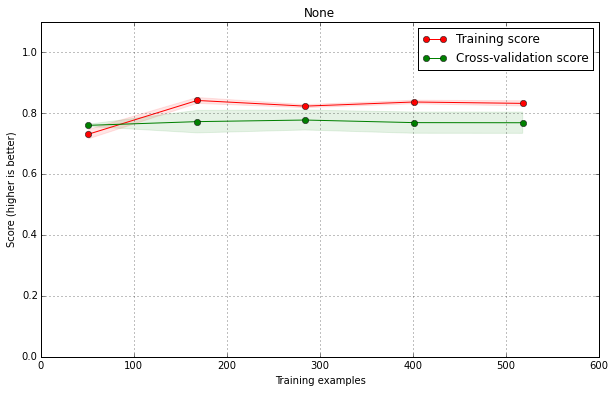

CPU times: user 264 ms, sys: 36 ms, total: 300 ms
Wall time: 411 ms


In [7]:
%%time

from sklearn_utilities import plot_learning_curve

plot_learning_curve(estimator   = clf, 
                    title       = None, 
                    X           = X_train, 
                    y           = y_train, 
                    ylim        = (0.0, 1.10), 
                    cv          = StratifiedKFold(y            = y_train, 
                                                  n_folds      = 10, 
                                                  shuffle      = True, 
                                                  random_state = SEED), 
                    train_sizes = np.linspace(.1, 1.0, 5),
                    n_jobs      = -1)

plt.show()

# Training set predictions

In [8]:
%%time

train_preds = cross_val_predict(estimator    = clf, 
                                X            = X_train, 
                                y            = y_train, 
                                cv           = StatifiedCV, 
                                n_jobs       = -1, 
                                verbose      = 0, 
                                fit_params   = None, 
                                pre_dispatch = '2*n_jobs')

y_true, y_pred   = y_train, train_preds

CPU times: user 56 ms, sys: 28 ms, total: 84 ms
Wall time: 180 ms


[[408  30]
 [100  38]]


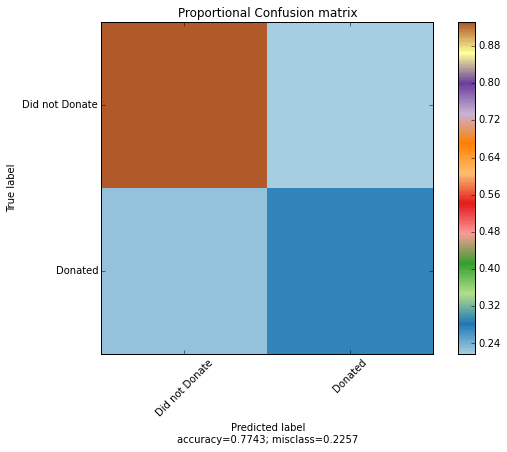

Accuracy 0.7743, mis-class rate 0.2257


In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

from sklearn_utilities import plot_confusion_matrix
plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy,misclass))

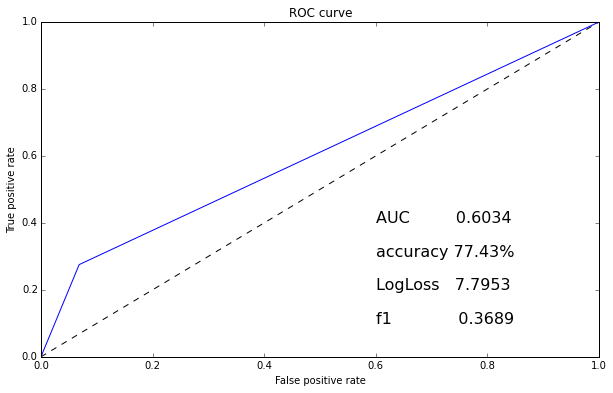

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

AUC = roc_auc_score(y_true, y_pred, average='macro')
plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(AUC),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

logloss = log_loss(y_true, y_pred)
plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(logloss),
        fontsize=16)

f1 = f1_score(y_true, y_pred)
plt.text(x=0.6,y=0.1,s="f1             {:.4f}"\
         .format(f1),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

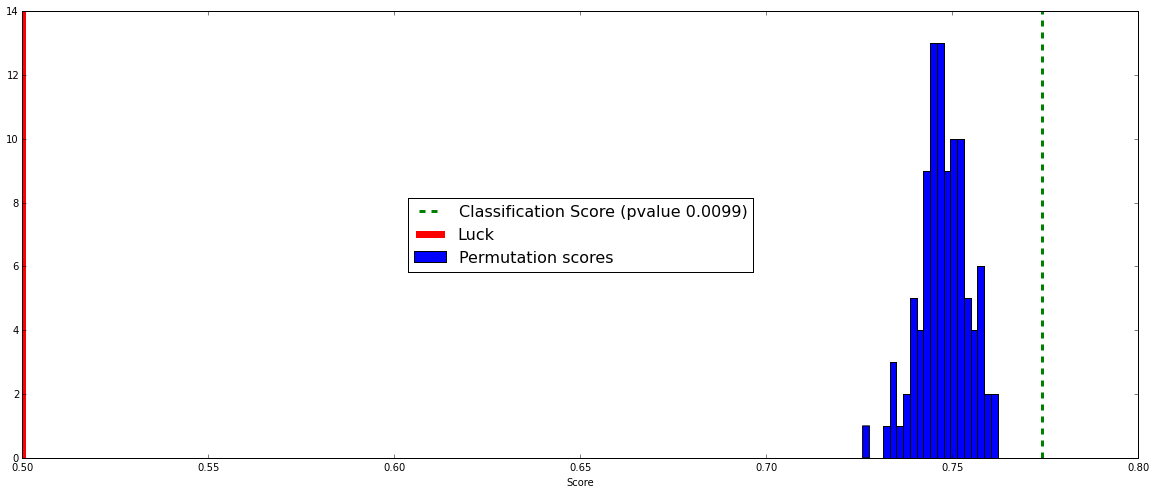

CPU times: user 492 ms, sys: 32 ms, total: 524 ms
Wall time: 2.24 s


In [11]:
%%time

score, permutation_scores, pvalue = permutation_test_score(estimator      = clf, 
                                                           X              = X_train.values.astype(np.float32), 
                                                           y              = y_train, 
                                                           cv             = StatifiedCV, 
                                                           labels         = None,
                                                           random_state   = SEED,
                                                           verbose        = 0,
                                                           n_permutations = 100, 
                                                           scoring        = None,
                                                           n_jobs         = -1) 

plt.figure(figsize=(20,8))
plt.hist(permutation_scores, 20, label='Permutation scores')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score (pvalue {:.4f})'.format(pvalue))
         
plt.plot(2 * [1. / N_CLASSES], ylim, 'r', linewidth=7, label='Luck')

plt.ylim(ylim)
plt.legend(loc='center',fontsize=16)
plt.xlabel('Score')
plt.show()

# find mean and stdev of the scores
from scipy.stats import norm
mu, std = norm.fit(permutation_scores)

In [12]:
# format for scores.csv file
import re
algo = re.search(r"submission_(.*?)\.csv", submission_filename).group(1)
print("{: <26} ,        ,   {:.4f} ,  {:.4f} , {:.4f} , {:.4f} , {:.4f} , {:.4f}"\
      .format(algo,accuracy,logloss,AUC,f1,mu,std))

XGBClassifier              ,        ,   0.7743 ,  7.7953 , 0.6034 , 0.3689 , 0.7474 , 0.0065


# --------------------------------------------------------------------------------------------

# Test Set Predictions

## Re-fit with the full training set

In [23]:
clf.set_params(**clf_params)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.75,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=50, nthread=1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.25)

## Read the test file 

In [24]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept)

# Predict the test set with the fitted model

In [25]:
y_pred = clf.predict(X_test)
print(y_pred[:10])

try:
    y_pred_probs  = clf.predict_proba(X_test)
    print(y_pred_probs[:10])
    donate_probs  = [prob[1] for prob in y_pred_probs]
except Exception,e:
    print(e)
    donate_probs = [0.65 if x>0 else 1-0.65 for x in y_pred]
    
print(donate_probs[:10])

[0 0 0 0 0 1 0 0 0 0]
[[ 0.54337305  0.45662695]
 [ 0.84477717  0.15522283]
 [ 0.8537997   0.14620033]
 [ 0.87041426  0.12958573]
 [ 0.52170396  0.47829607]
 [ 0.39677262  0.60322738]
 [ 0.74567413  0.2543259 ]
 [ 0.93163395  0.06836602]
 [ 0.91820771  0.08179232]
 [ 0.94629264  0.05370735]]
[0.45662695, 0.15522283, 0.14620033, 0.12958573, 0.47829607, 0.60322738, 0.2543259, 0.068366021, 0.081792317, 0.053707346]


# Create the submission file

In [13]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()